## Submission Dicoding Time-Series

Nama : Muhammad Rizq Ramadhan

### Dataset Description

Dataset ini merupakan konsumsi energi setiap jam yang dihasilkan oleh The Dayton Power and Light Company dan DPL Energy Resources untuk wilayah Dayton dan Ohio.

Link untuk Dataset:

https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=DAYTON_hourly.csv

### Setting Up The Dataset

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
csv = '/content/drive/MyDrive/time_series/DAYTON_hourly.csv'

### Data Preparation

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [101]:
ts = pd.read_csv(csv)
ts.head(5)

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


In [102]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121275 entries, 0 to 121274
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Datetime   121275 non-null  object 
 1   DAYTON_MW  121275 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [103]:
ts.isnull().sum()

Datetime     0
DAYTON_MW    0
dtype: int64

In [104]:
ts['Datetime'] = pd.to_datetime(ts['Datetime'])

### Normalization Dataset

In [105]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [106]:
data = ts['DAYTON_MW'].values.reshape(-1,1)
scaler = min_max_scaler.fit_transform(data)

In [107]:
ts['DAYTON_MW'] = scaler

### Plotting Dataset

In [108]:
date = ts['Datetime'].values
energy = ts['DAYTON_MW'].values

In [109]:
energy

array([0.22214182, 0.19356006, 0.18234443, ..., 0.60853835, 0.59044863,
       0.56801737])

In [110]:
date

array(['2004-12-31T01:00:00.000000000', '2004-12-31T02:00:00.000000000',
       '2004-12-31T03:00:00.000000000', ...,
       '2018-01-01T22:00:00.000000000', '2018-01-01T23:00:00.000000000',
       '2018-01-02T00:00:00.000000000'], dtype='datetime64[ns]')

<Axes: xlabel='Datetime'>

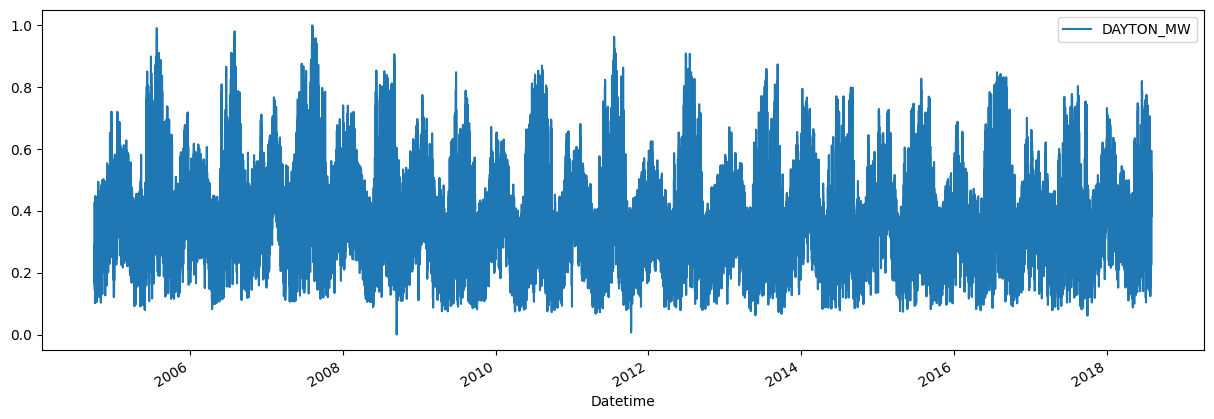

In [111]:
ts.set_index('Datetime').plot(figsize=(15,5))

### Splitting Dataset

In [112]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [113]:
date_train, date_test, energy_train, energy_test = train_test_split(date,
                                                                    energy,
                                                                    test_size=0.2,
                                                                    shuffle=False)

### Building Architecture

In [114]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [115]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [116]:
train_set = windowed_dataset(energy_train,
                             window_size=60,
                             batch_size=100,
                             shuffle_buffer=1000)

In [117]:
val_set = windowed_dataset(energy_test,
                           window_size=60,
                           batch_size=100,
                           shuffle_buffer=1000)

In [118]:
model = Sequential([
    LSTM(60, return_sequences=True, input_shape=(60, 1)),
    LSTM(60),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(1)
])

### Compiling The Model

In [119]:
from tensorflow.keras.callbacks import EarlyStopping

In [120]:
early_stopping = EarlyStopping(monitor='val_mae',
                               patience=3,
                               restore_best_weights=True,
                               min_delta=0.1)

In [121]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

### Training Model

In [122]:
history = model.fit(train_set,
                    epochs=10 ,
                    validation_data=val_set,
                    callbacks=[early_stopping])

Epoch 1/10
970/970 [==============================] - 157s 156ms/step - loss: 0.0101 - mae: 0.1121 - val_loss: 0.0089 - val_mae: 0.1063
Epoch 2/10
970/970 [==============================] - 153s 158ms/step - loss: 0.0076 - mae: 0.0976 - val_loss: 0.0063 - val_mae: 0.0891
Epoch 3/10
970/970 [==============================] - 157s 161ms/step - loss: 0.0067 - mae: 0.0917 - val_loss: 0.0056 - val_mae: 0.0840
Epoch 4/10
970/970 [==============================] - 153s 157ms/step - loss: 0.0060 - mae: 0.0864 - val_loss: 0.0045 - val_mae: 0.0749


### Threshold

In [123]:
threshold_mae = (ts['DAYTON_MW'].max() - ts['DAYTON_MW'].min()) * 10/100
print(f"threshold: {threshold_mae}")

threshold: 0.1


### Visualization MAE and Loss

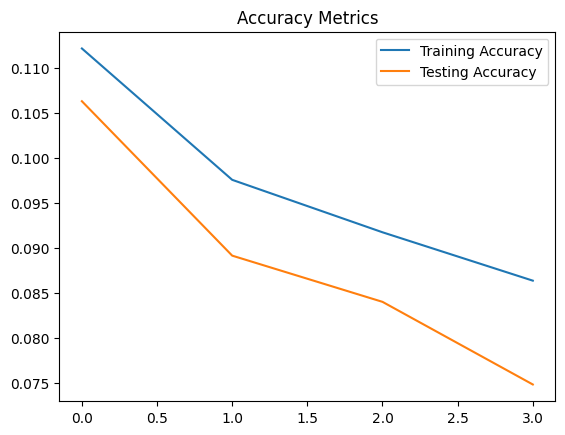

In [124]:
plt.plot(history.history['mae'], label='Training Accuracy')
plt.plot(history.history['val_mae'], label='Testing Accuracy')
plt.title('Accuracy Metrics')
plt.legend()
plt.show()

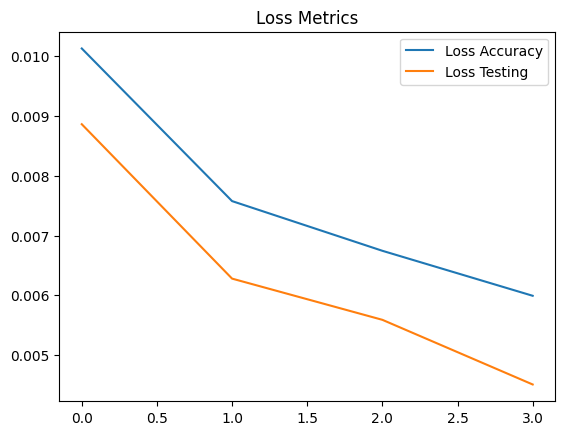

In [125]:
plt.plot(history.history['loss'], label='Loss Accuracy')
plt.plot(history.history['val_loss'], label='Loss Testing')
plt.title('Loss Metrics')
plt.legend()
plt.show()